## 변동사항
* 피쳐는 bow 기반 데이터를 level별로 생성하였다.
* 기존 모델링의 문제점 - DAE 내부 Random Seed로 인해 파라미터 튜닝 후 최적의 파라미터로 다시 학습시켰을 때  
그 때 성능이 구현되지 않는다.
* 해결방안 - 그래프나 성능 확인을 통해 우수한 모델로 판단될 시, 해당 submit을 저장해둔다.

In [1]:
%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# tf.logging.set_verbosity(tf.logging.ERROR)

# from tensorflow import set_random_seed
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


### Read Data

In [2]:
tr_train = pd.read_csv('X_train.csv', encoding='cp949')
tr_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = tr_test.cust_id.unique()

tr_train.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000


### Make BOW-based Features

In [4]:
features = ['goods_id', 'gds_grp_nm', 'gds_grp_mclas_nm']

tr_all = pd.concat([tr_train, tr_test])
train = []
test = []

for f in features:
    for d,q in zip([train, test], ['cust_id not in @IDtest', 'cust_id in @IDtest']):
        d.append(pd.pivot_table(tr_all, index='cust_id', columns=f, values='amount',
                                aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0)                 
                 .reset_index()
                 .query(q)
                 .drop(columns=['cust_id']).values)
 
train, test = np.hstack(train),  np.hstack(test)

train.shape, test.shape

((3500, 4179), (2482, 4179))

### Build Models with DAE
#### [Basic]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

DAE learning curve 1/10


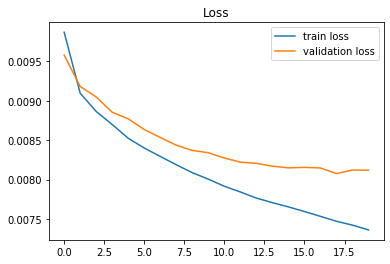

DNN learning curve 1/10


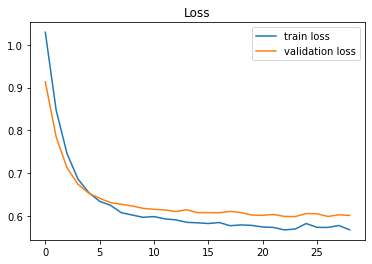

AUC 0.7297371893840727


 10%|████████▎                                                                          | 1/10 [01:32<13:51, 92.39s/it]

DAE learning curve 2/10


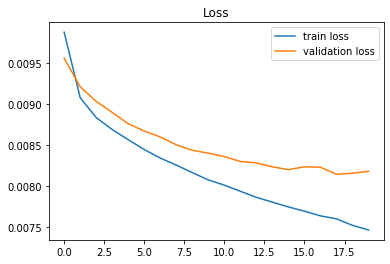

DNN learning curve 2/10


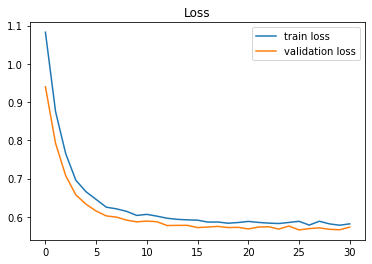

 20%|████████████████▌                                                                  | 2/10 [03:06<12:22, 92.83s/it]

AUC 0.762777665545318
DAE learning curve 3/10


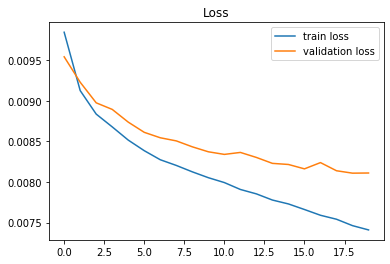

DNN learning curve 3/10


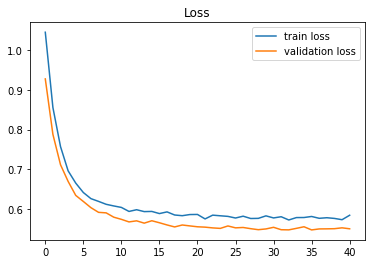

 30%|████████████████████████▉                                                          | 3/10 [04:41<10:54, 93.53s/it]

AUC 0.7879135390603281
DAE learning curve 4/10


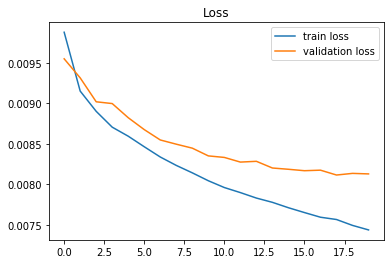

DNN learning curve 4/10


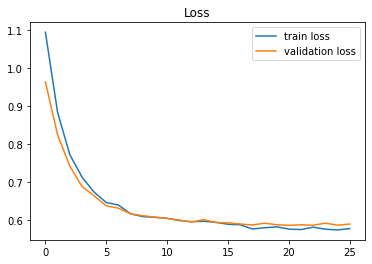

 40%|█████████████████████████████████▏                                                 | 4/10 [06:17<09:25, 94.28s/it]

AUC 0.7473655803433741
DAE learning curve 5/10


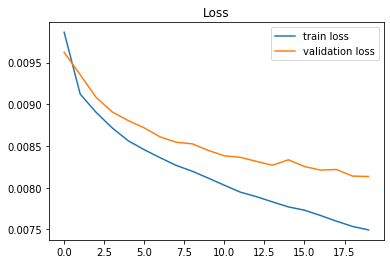

DNN learning curve 5/10


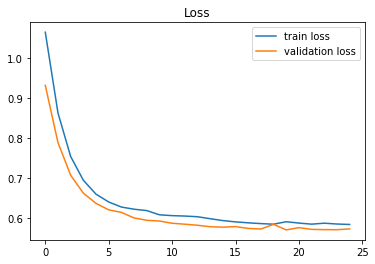

 50%|█████████████████████████████████████████▌                                         | 5/10 [07:52<07:52, 94.58s/it]

AUC 0.7619397725591877
DAE learning curve 6/10


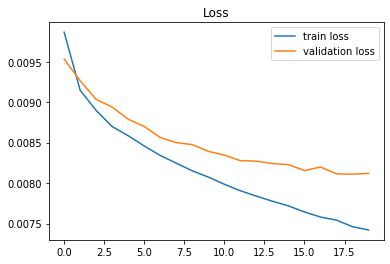

DNN learning curve 6/10


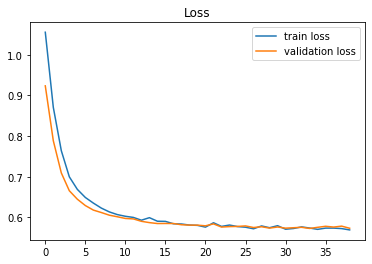

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [09:30<06:22, 95.61s/it]

AUC 0.7609684148055054
DAE learning curve 7/10


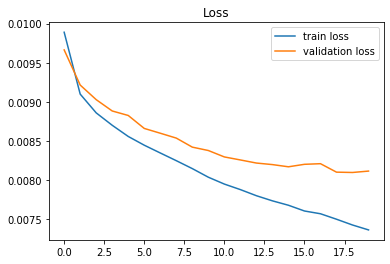

DNN learning curve 7/10


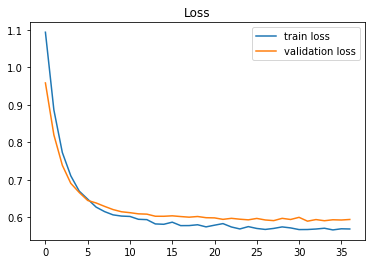

 70%|██████████████████████████████████████████████████████████                         | 7/10 [11:10<04:50, 96.85s/it]

AUC 0.7422417112299464
DAE learning curve 8/10


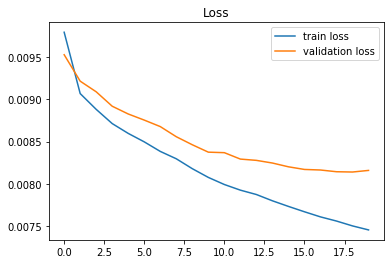

DNN learning curve 8/10


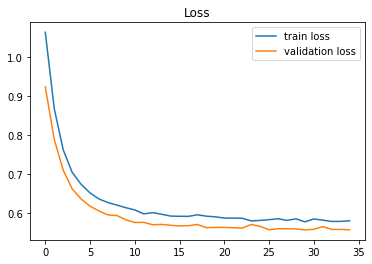

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [12:52<03:16, 98.33s/it]

AUC 0.7650735981620496
DAE learning curve 9/10


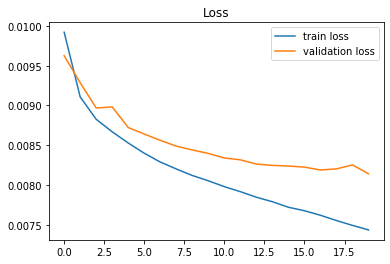

DNN learning curve 9/10


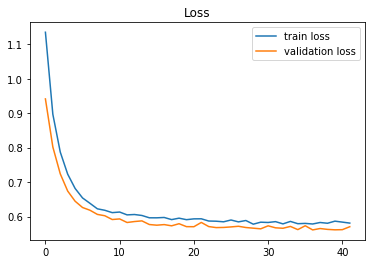

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [14:35<01:39, 99.71s/it]

AUC 0.7546284600671262
DAE learning curve 10/10


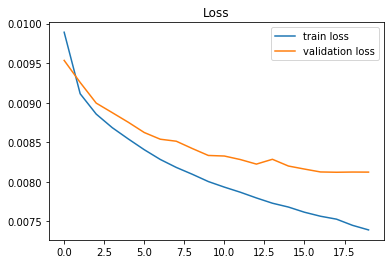

DNN learning curve 10/10


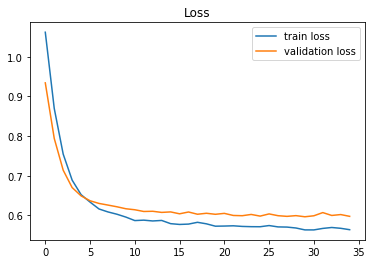

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [16:20<00:00, 98.05s/it]

AUC 0.7254763280690708

Validation Summary:
2    0.787914
7    0.765074
1    0.762778
4    0.761940
5    0.760968
8    0.754628
3    0.747366
6    0.742242
0    0.729737
9    0.725476
dtype: float64
mean=0.75381, std=0.018


In [4]:
# Set hyper-parameters for power mean ensemble 
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    X_train, X_test = train, test

    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    ##### STEP 2: Build DAE #####
    
    # Define the encoder dimension
    encoding_dim = 128

    # Input Layer
    input_dim = Input(shape = (X_train.shape[1], ))

    # Encoder Layers
    noise = Dropout(0.5)(input_dim) # for Denoising
    encoded1 = Dense(512, activation = 'relu')(noise)
    encoded2 = Dense(256, activation = 'relu')(encoded1)
    encoded3 = Dense(128, activation = 'relu')(encoded2)
    encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

    # Decoder Layers
    decoded1 = Dense(128, activation = 'relu')(encoded4)
    decoded2 = Dense(256, activation = 'relu')(decoded1)
    decoded3 = Dense(512, activation = 'relu')(decoded2)
    decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded4)

    # Compile the model
    autoencoder.compile(optimizer = 'adam', loss = 'mse')

    # Train the model
    history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                              shuffle=True, validation_data=(X_test,X_test), verbose=0)

    print(f'DAE learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    ##### STEP 3: Reduce Dimension #####
        
    # Use a middle Bottleneck Layer to Reduce Dimension
    model = Model(inputs=input_dim, outputs=encoded4)
    X_train = model.predict(X_train)
    X_test = model.predict(X_test)

    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=100, batch_size=64, 
                        validation_data=(valid_x,valid_y), callbacks=[EarlyStopping(patience=5)], verbose=0)

    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))     

[elu]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

DAE learning curve 1/10


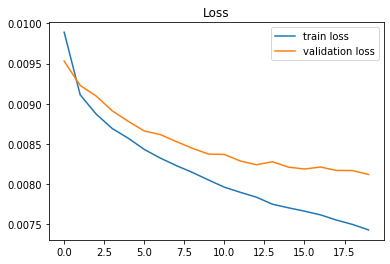

DNN learning curve 1/10


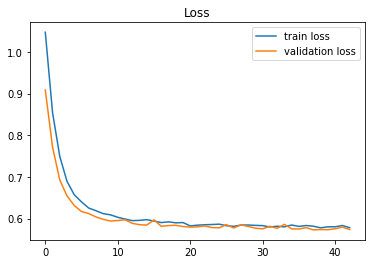

AUC 0.7524326083896398


 10%|████████▏                                                                         | 1/10 [03:09<28:22, 189.20s/it]

DAE learning curve 2/10


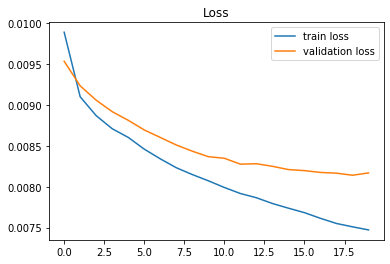

DNN learning curve 2/10


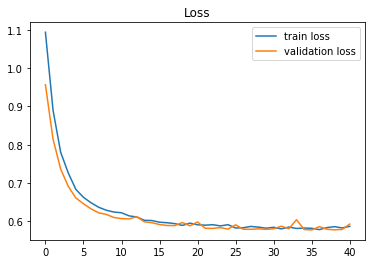

AUC 0.7549948100299388


 20%|████████████████▍                                                                 | 2/10 [06:23<25:26, 190.86s/it]

DAE learning curve 3/10


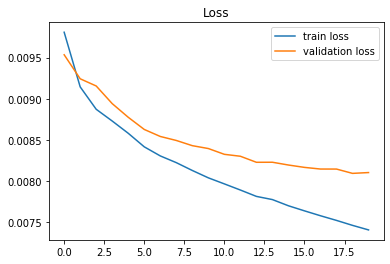

DNN learning curve 3/10


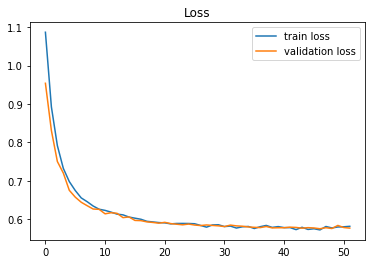

AUC 0.7476470639735946


 30%|████████████████████████▌                                                         | 3/10 [09:34<22:15, 190.84s/it]

DAE learning curve 4/10


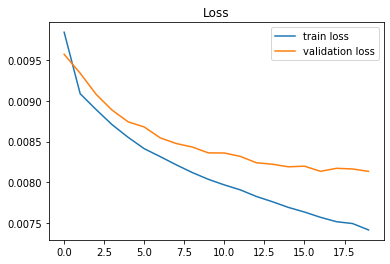

DNN learning curve 4/10


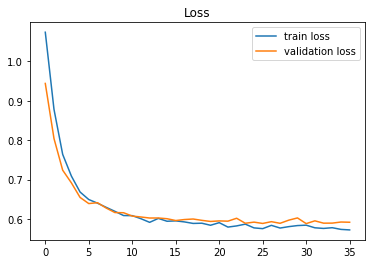

AUC 0.7456535184167126


 40%|████████████████████████████████▊                                                 | 4/10 [12:31<18:39, 186.58s/it]

DAE learning curve 5/10


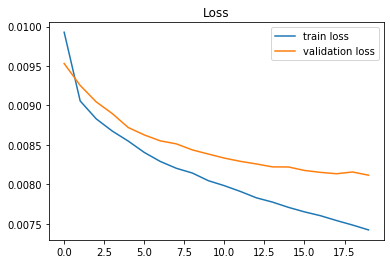

DNN learning curve 5/10


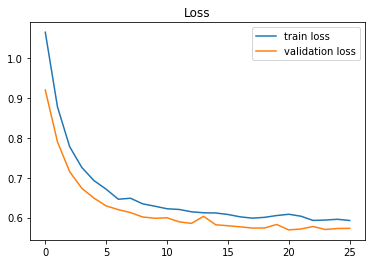

AUC 0.7686705242670996


 50%|█████████████████████████████████████████                                         | 5/10 [15:25<15:13, 182.70s/it]

DAE learning curve 6/10


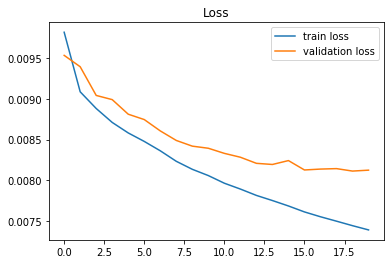

DNN learning curve 6/10


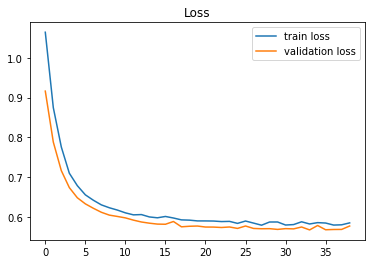

AUC 0.7629006332838535


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:38<12:23, 185.95s/it]

DAE learning curve 7/10


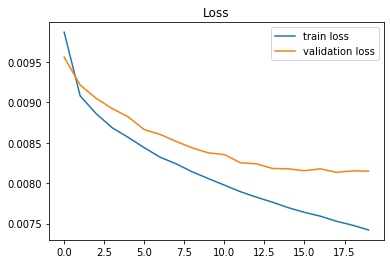

DNN learning curve 7/10


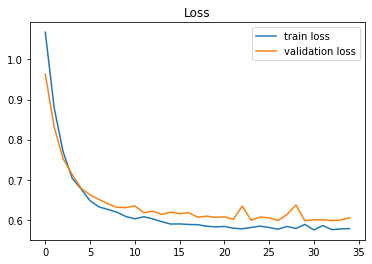

AUC 0.7297327138840995


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:31<09:06, 182.11s/it]

DAE learning curve 8/10


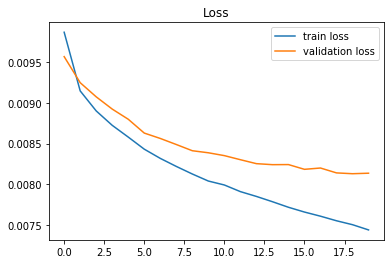

DNN learning curve 8/10


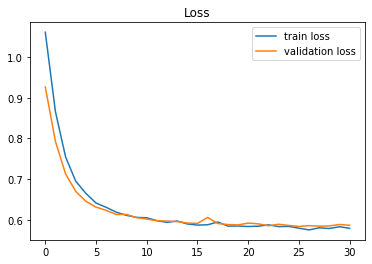

AUC 0.7488971643855878


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [24:27<06:00, 180.22s/it]

DAE learning curve 9/10


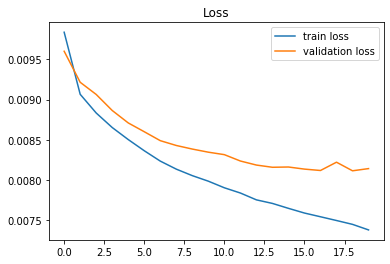

DNN learning curve 9/10


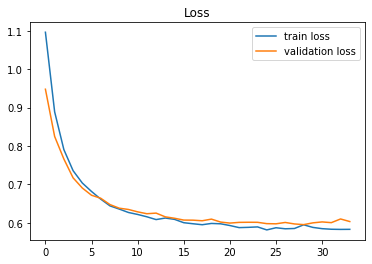

AUC 0.740659965034965


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [27:32<03:01, 181.62s/it]

DAE learning curve 10/10


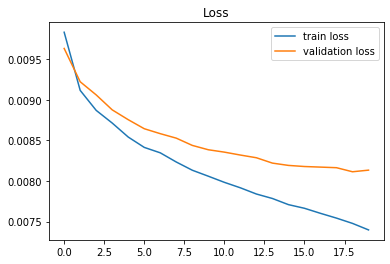

DNN learning curve 10/10


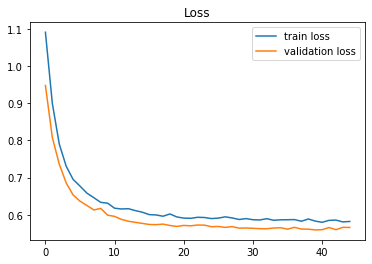

AUC 0.7674735357012928


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [30:31<00:00, 183.18s/it]



Validation Summary:
4    0.768671
9    0.767474
5    0.762901
1    0.754995
0    0.752433
7    0.748897
2    0.747647
3    0.745654
8    0.740660
6    0.729733
dtype: float64
mean=0.75191, std=0.012


In [4]:
# Set hyper-parameters for power mean ensemble 
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    X_train, X_test = train, test

    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    ##### STEP 2: Build DAE #####
    
    # Define the encoder dimension
    encoding_dim = 128

    # Input Layer
    input_dim = Input(shape = (X_train.shape[1], ))

    # Encoder Layers
    noise = Dropout(0.5)(input_dim) # for Denoising
    encoded1 = Dense(512, activation = 'relu')(noise)
    encoded2 = Dense(256, activation = 'relu')(encoded1)
    encoded3 = Dense(128, activation = 'relu')(encoded2)
    encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

    # Decoder Layers
    decoded1 = Dense(128, activation = 'relu')(encoded4)
    decoded2 = Dense(256, activation = 'relu')(decoded1)
    decoded3 = Dense(512, activation = 'relu')(decoded2)
    decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded4)

    # Compile the model
    autoencoder.compile(optimizer = 'adam', loss = 'mse')

    # Train the model
    history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                              shuffle=True, validation_data=(X_test,X_test), verbose=0)

    print(f'DAE learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    ##### STEP 3: Reduce Dimension #####
        
    # Use a middle Bottleneck Layer to Reduce Dimension
    model = Model(inputs=input_dim, outputs=encoded4)
    X_train = model.predict(X_train)
    X_test = model.predict(X_test)

    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(32, activation='elu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='elu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=100, batch_size=64, 
                        validation_data=(valid_x,valid_y), callbacks=[EarlyStopping(patience=5)], verbose=0)

    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))     

[Less Dropout, More L2]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

DAE learning curve 1/10


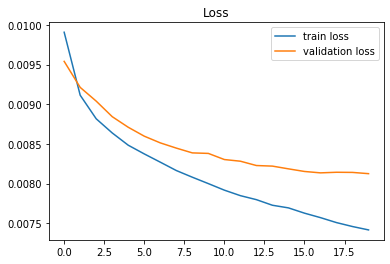

DNN learning curve 1/10


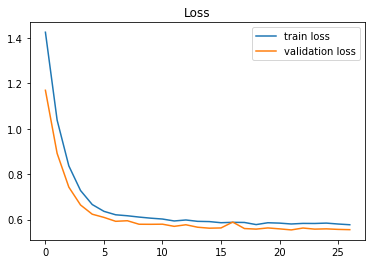

AUC 0.769220132743363


 10%|████████▏                                                                         | 1/10 [02:52<25:55, 172.78s/it]

DAE learning curve 2/10


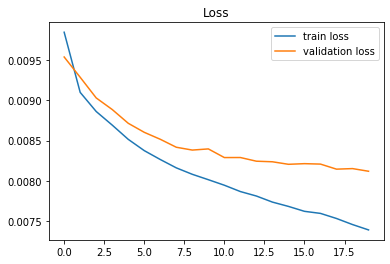

DNN learning curve 2/10


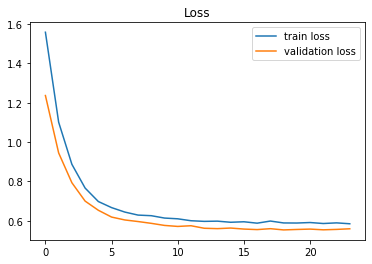

AUC 0.7877683131618102


 20%|████████████████▍                                                                 | 2/10 [05:45<23:02, 172.84s/it]

DAE learning curve 3/10


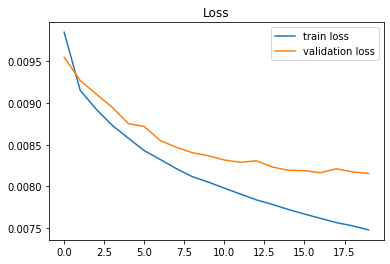

DNN learning curve 3/10


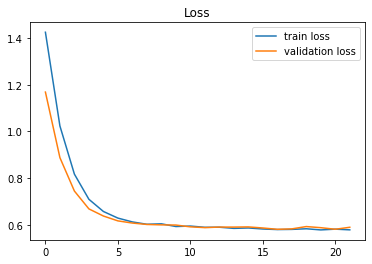

AUC 0.7539622641509435


 30%|████████████████████████▌                                                         | 3/10 [08:49<20:32, 176.14s/it]

DAE learning curve 4/10


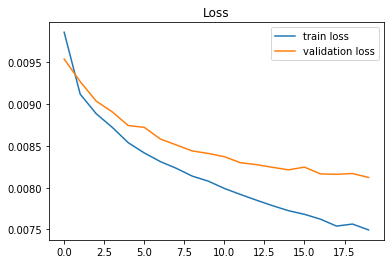

DNN learning curve 4/10


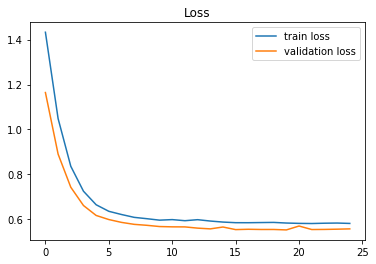

AUC 0.7814166166448925


 40%|████████████████████████████████▊                                                 | 4/10 [11:49<17:42, 177.16s/it]

DAE learning curve 5/10


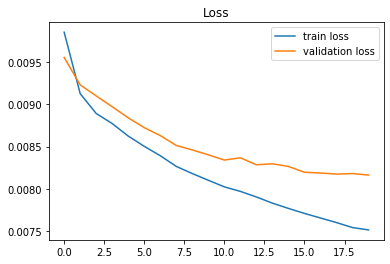

DNN learning curve 5/10


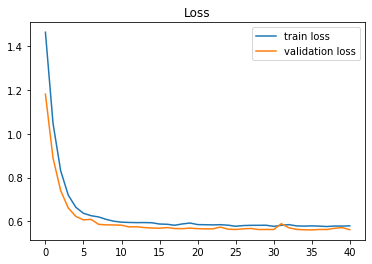

AUC 0.7634991496598641


 50%|█████████████████████████████████████████                                         | 5/10 [14:42<14:40, 176.02s/it]

DAE learning curve 6/10


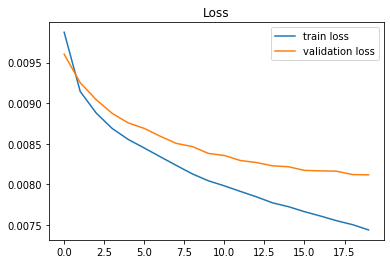

DNN learning curve 6/10


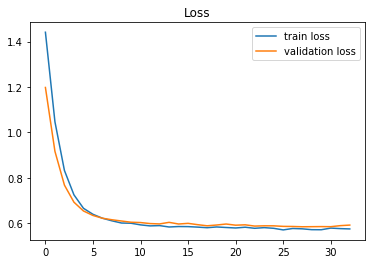

AUC 0.7495630718618278


 60%|█████████████████████████████████████████████████▏                                | 6/10 [17:35<11:40, 175.21s/it]

DAE learning curve 7/10


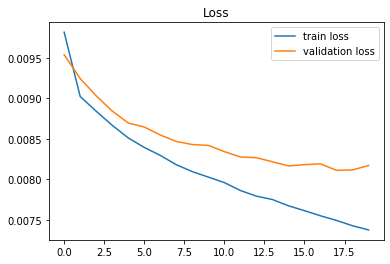

DNN learning curve 7/10


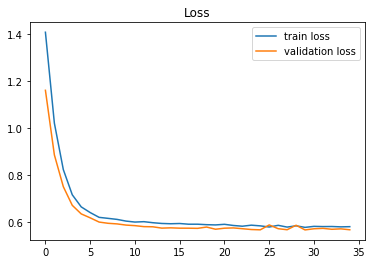

AUC 0.773325214206744


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [20:26<08:41, 173.94s/it]

DAE learning curve 8/10


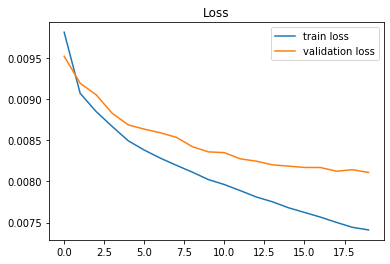

DNN learning curve 8/10


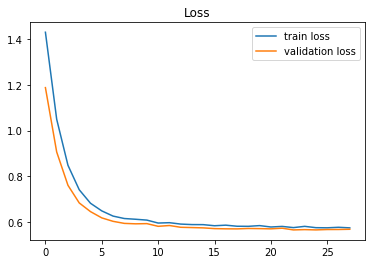

AUC 0.769611175014814


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [23:16<05:45, 172.81s/it]

DAE learning curve 9/10


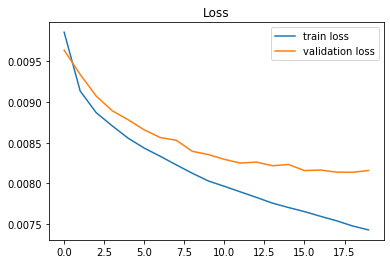

DNN learning curve 9/10


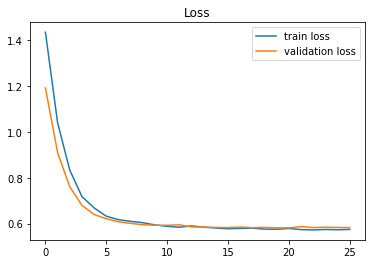

AUC 0.7425681363779859


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [26:05<02:51, 171.50s/it]

DAE learning curve 10/10


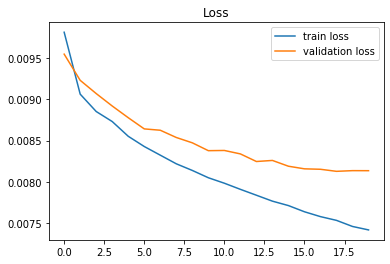

DNN learning curve 10/10


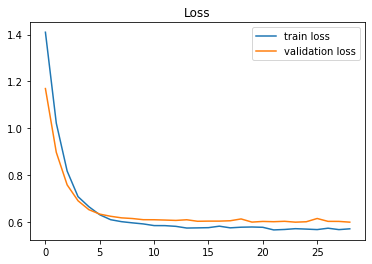

AUC 0.7324419655268279


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [28:58<00:00, 173.87s/it]



Validation Summary:
1    0.787768
3    0.781417
6    0.773325
7    0.769611
0    0.769220
4    0.763499
2    0.753962
5    0.749563
8    0.742568
9    0.732442
dtype: float64
mean=0.76234, std=0.017


In [5]:
# Set hyper-parameters for power mean ensemble 
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    X_train, X_test = train, test

    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    ##### STEP 2: Build DAE #####
    
    # Define the encoder dimension
    encoding_dim = 128

    # Input Layer
    input_dim = Input(shape = (X_train.shape[1], ))

    # Encoder Layers
    noise = Dropout(0.5)(input_dim) # for Denoising
    encoded1 = Dense(512, activation = 'relu')(noise)
    encoded2 = Dense(256, activation = 'relu')(encoded1)
    encoded3 = Dense(128, activation = 'relu')(encoded2)
    encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

    # Decoder Layers
    decoded1 = Dense(128, activation = 'relu')(encoded4)
    decoded2 = Dense(256, activation = 'relu')(decoded1)
    decoded3 = Dense(512, activation = 'relu')(decoded2)
    decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded4)

    # Compile the model
    autoencoder.compile(optimizer = 'adam', loss = 'mse')

    # Train the model
    history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                              shuffle=True, validation_data=(X_test,X_test), verbose=0)

    print(f'DAE learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    ##### STEP 3: Reduce Dimension #####
        
    # Use a middle Bottleneck Layer to Reduce Dimension
    model = Model(inputs=input_dim, outputs=encoded4)
    X_train = model.predict(X_train)
    X_test = model.predict(X_test)

    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.02)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=100, batch_size=64, 
                        validation_data=(valid_x,valid_y), callbacks=[EarlyStopping(patience=5)], verbose=0)

    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))     

In [6]:
# Power mean ensemble
THRESHOLD = 0.77  # Use only models whose AUC exceeds this value, 787914

pred = 0
n = 0
for i in range(N):
    if aucs.iloc[i] > THRESHOLD:
        pred = pred + preds[i]**p 
        n += 1
pred = pred / n    
pred = pred**(1/p)

# Make a submission file
t = pd.Timestamp.now()
fname = f"dae_p{p}n{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'dae_p3.5n3_submit_06140846.csv' is ready to submit.


[adam->nadam]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

DAE learning curve 1/10


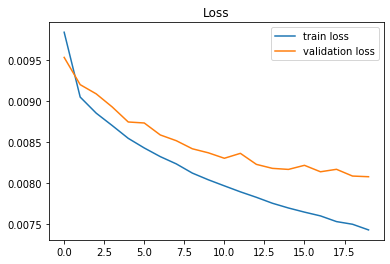

DNN learning curve 1/10


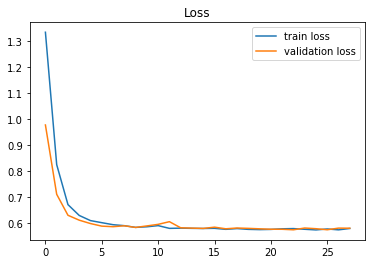

AUC 0.7574192767124236


 10%|████████▏                                                                         | 1/10 [02:48<25:12, 168.08s/it]

DAE learning curve 2/10


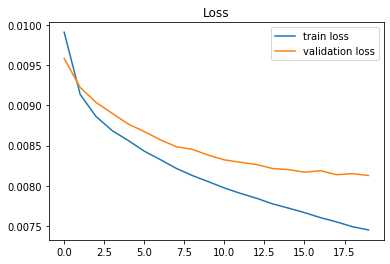

DNN learning curve 2/10


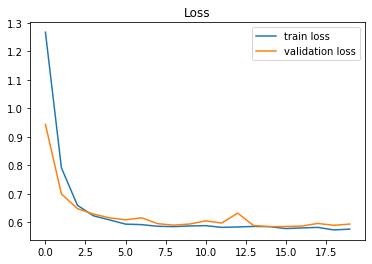

AUC 0.7648192771084338


 20%|████████████████▍                                                                 | 2/10 [05:36<22:26, 168.29s/it]

DAE learning curve 3/10


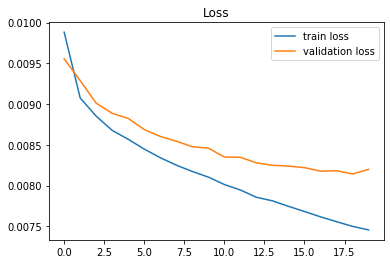

DNN learning curve 3/10


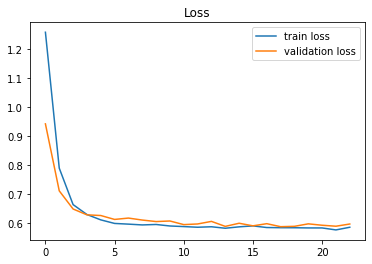

AUC 0.7542380046501795


 30%|████████████████████████▌                                                         | 3/10 [08:23<19:35, 167.94s/it]

DAE learning curve 4/10


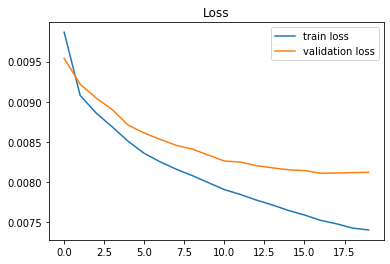

DNN learning curve 4/10


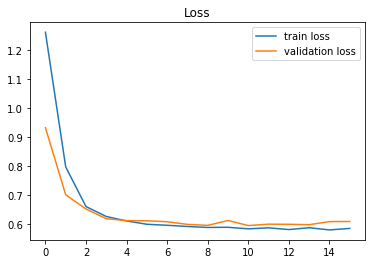

AUC 0.7370638726716708


 40%|████████████████████████████████▊                                                 | 4/10 [11:13<16:50, 168.41s/it]

DAE learning curve 5/10


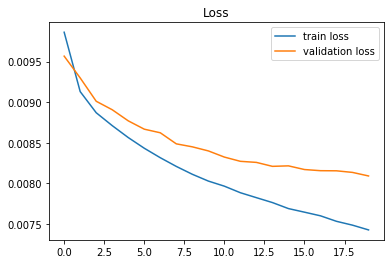

DNN learning curve 5/10


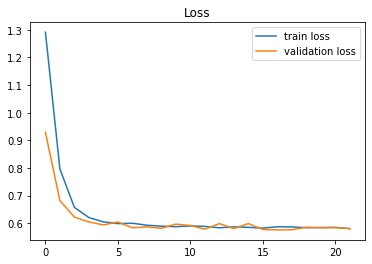

AUC 0.7579072647583245


 50%|█████████████████████████████████████████                                         | 5/10 [14:01<14:01, 168.27s/it]

DAE learning curve 6/10


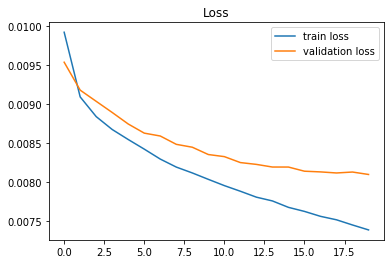

DNN learning curve 6/10


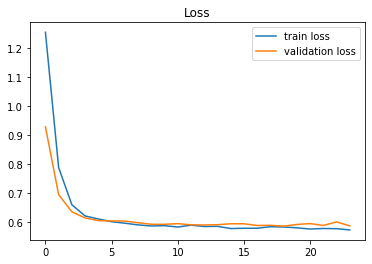

AUC 0.7473553554592557


 60%|█████████████████████████████████████████████████▏                                | 6/10 [16:50<11:13, 168.50s/it]

DAE learning curve 7/10


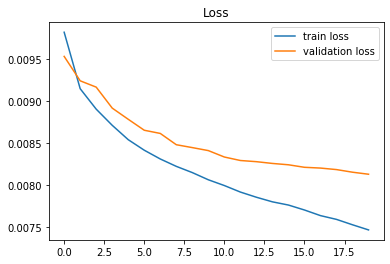

DNN learning curve 7/10


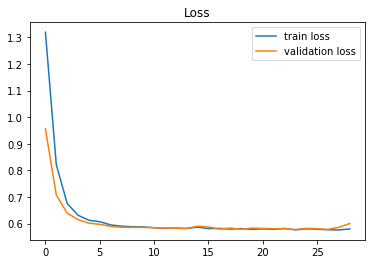

AUC 0.748759754245966


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [19:47<08:33, 171.03s/it]

DAE learning curve 8/10


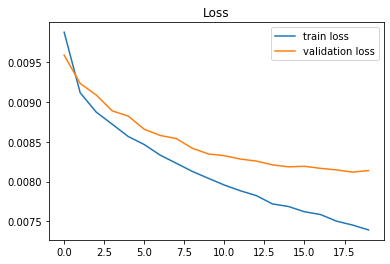

DNN learning curve 8/10


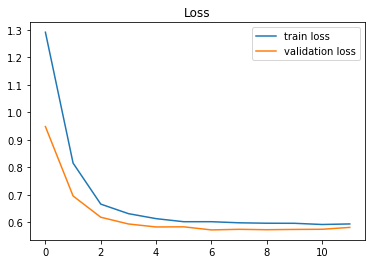

AUC 0.7923339160839161


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [22:35<05:40, 170.06s/it]

DAE learning curve 9/10


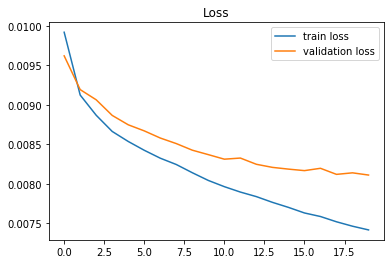

DNN learning curve 9/10


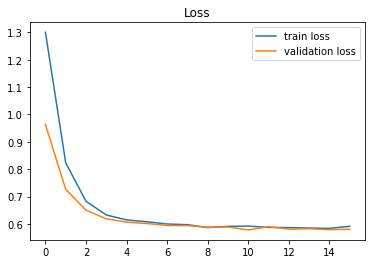

AUC 0.7579348530155547


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [25:27<02:50, 170.87s/it]

DAE learning curve 10/10


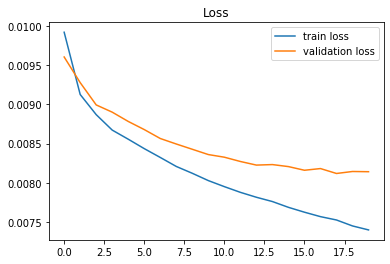

DNN learning curve 10/10


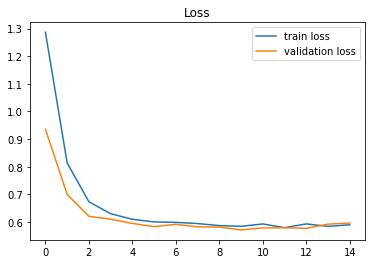

AUC 0.7447141018569591


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [28:17<00:00, 169.70s/it]



Validation Summary:
7    0.792334
1    0.764819
8    0.757935
4    0.757907
0    0.757419
2    0.754238
6    0.748760
5    0.747355
9    0.744714
3    0.737064
dtype: float64
mean=0.75625, std=0.015


In [7]:
# Set hyper-parameters for power mean ensemble 
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    X_train, X_test = train, test

    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    ##### STEP 2: Build DAE #####
    
    # Define the encoder dimension
    encoding_dim = 128

    # Input Layer
    input_dim = Input(shape = (X_train.shape[1], ))

    # Encoder Layers
    noise = Dropout(0.5)(input_dim) # for Denoising
    encoded1 = Dense(512, activation = 'relu')(noise)
    encoded2 = Dense(256, activation = 'relu')(encoded1)
    encoded3 = Dense(128, activation = 'relu')(encoded2)
    encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

    # Decoder Layers
    decoded1 = Dense(128, activation = 'relu')(encoded4)
    decoded2 = Dense(256, activation = 'relu')(decoded1)
    decoded3 = Dense(512, activation = 'relu')(decoded2)
    decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded4)

    # Compile the model
    autoencoder.compile(optimizer = 'adam', loss = 'mse')

    # Train the model
    history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                              shuffle=True, validation_data=(X_test,X_test), verbose=0)

    print(f'DAE learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    ##### STEP 3: Reduce Dimension #####
        
    # Use a middle Bottleneck Layer to Reduce Dimension
    model = Model(inputs=input_dim, outputs=encoded4)
    X_train = model.predict(X_train)
    X_test = model.predict(X_test)

    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.02)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['acc'])
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=100, batch_size=64, 
                        validation_data=(valid_x,valid_y), callbacks=[EarlyStopping(patience=5)], verbose=0)

    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))     

In [8]:
# Power mean ensemble
THRESHOLD = 0.76  # Use only models whose AUC exceeds this value

pred = 0
n = 0
for i in range(N):
    if aucs.iloc[i] > THRESHOLD:
        pred = pred + preds[i]**p 
        n += 1
pred = pred / n    
pred = pred**(1/p)

# Make a submission file
t = pd.Timestamp.now()
fname = f"dae_p{p}n{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'dae_p3.5n2_submit_06140917.csv' is ready to submit.


[nadam, elu]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

DAE learning curve 1/10


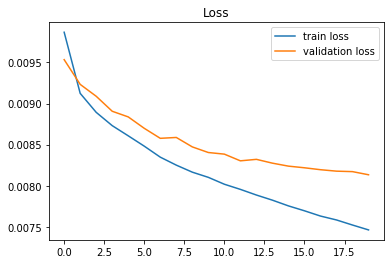

DNN learning curve 1/10


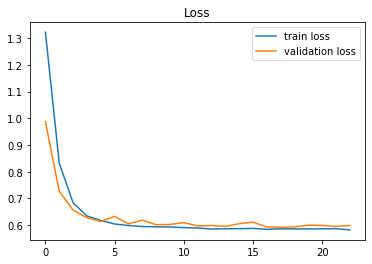

AUC 0.7459310499486799


 10%|████████▏                                                                         | 1/10 [04:55<44:20, 295.66s/it]

DAE learning curve 2/10


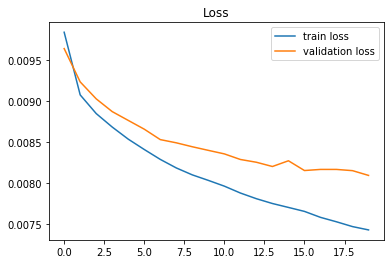

DNN learning curve 2/10


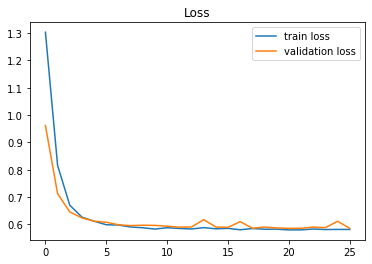

AUC 0.7478615641880948


 20%|████████████████▍                                                                 | 2/10 [10:41<41:25, 310.75s/it]

DAE learning curve 3/10


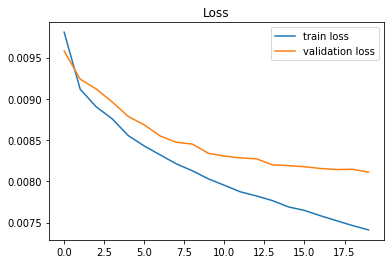

DNN learning curve 3/10


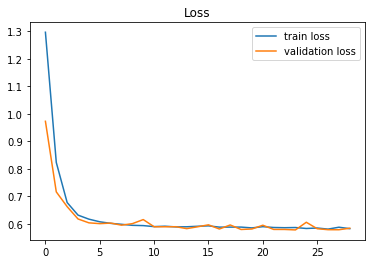

AUC 0.7535392535392537


 30%|████████████████████████▌                                                         | 3/10 [16:16<37:05, 317.99s/it]

DAE learning curve 4/10


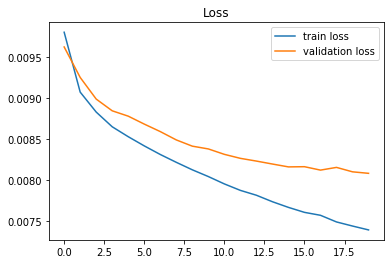

DNN learning curve 4/10


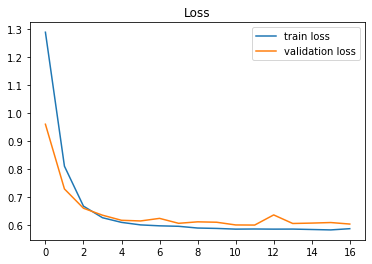

AUC 0.7341360543044186


 40%|████████████████████████████████▊                                                 | 4/10 [23:24<35:06, 351.04s/it]

DAE learning curve 5/10


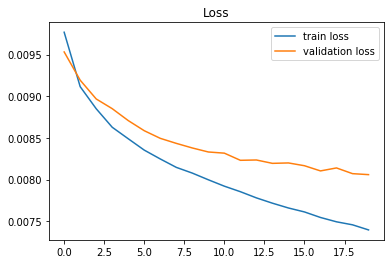

DNN learning curve 5/10


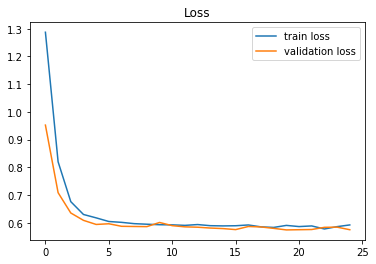

AUC 0.7712002443245445


 50%|█████████████████████████████████████████                                         | 5/10 [26:19<24:50, 298.12s/it]

DAE learning curve 6/10


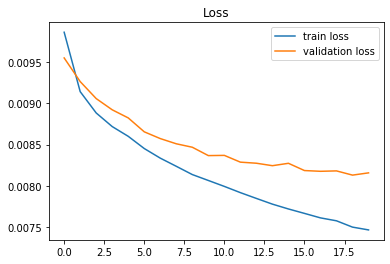

DNN learning curve 6/10


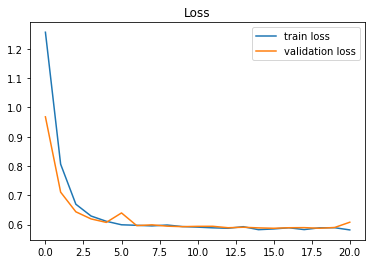

AUC 0.747308507261669


 60%|█████████████████████████████████████████████████▏                                | 6/10 [29:17<17:28, 262.04s/it]

DAE learning curve 7/10


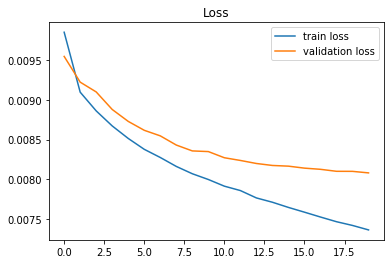

DNN learning curve 7/10


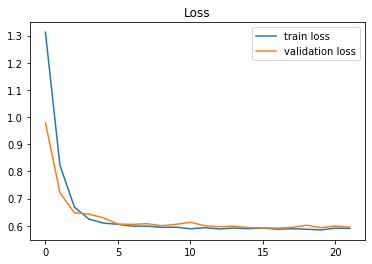

AUC 0.7386146441479011


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [32:07<11:43, 234.61s/it]

DAE learning curve 8/10


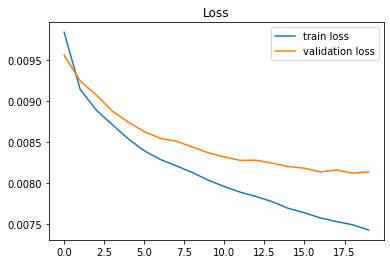

DNN learning curve 8/10


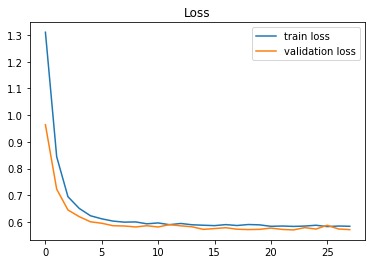

AUC 0.7508857709750567


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [35:00<07:12, 216.16s/it]

KeyboardInterrupt: 

In [5]:
# BEST  아니라 중지
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    X_train, X_test = train, test

    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    ##### STEP 2: Build DAE #####
    
    # Define the encoder dimension
    encoding_dim = 128

    # Input Layer
    input_dim = Input(shape = (X_train.shape[1], ))

    # Encoder Layers
    noise = Dropout(0.5)(input_dim) # for Denoising
    encoded1 = Dense(512, activation = 'relu')(noise)
    encoded2 = Dense(256, activation = 'relu')(encoded1)
    encoded3 = Dense(128, activation = 'relu')(encoded2)
    encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

    # Decoder Layers
    decoded1 = Dense(128, activation = 'relu')(encoded4)
    decoded2 = Dense(256, activation = 'relu')(decoded1)
    decoded3 = Dense(512, activation = 'relu')(decoded2)
    decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded4)

    # Compile the model
    autoencoder.compile(optimizer = 'adam', loss = 'mse')

    # Train the model
    history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                              shuffle=True, validation_data=(X_test,X_test), verbose=0)

    print(f'DAE learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    ##### STEP 3: Reduce Dimension #####
        
    # Use a middle Bottleneck Layer to Reduce Dimension
    model = Model(inputs=input_dim, outputs=encoded4)
    X_train = model.predict(X_train)
    X_test = model.predict(X_test)

    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(32, activation='elu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.02)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='elu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['acc'])
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=100, batch_size=64, 
                        validation_data=(valid_x,valid_y), callbacks=[EarlyStopping(patience=5)], verbose=0)

    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))     

[More Dense]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

DAE learning curve 1/10


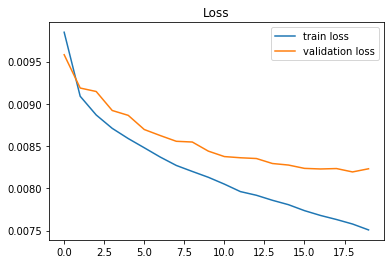

DNN learning curve 1/10


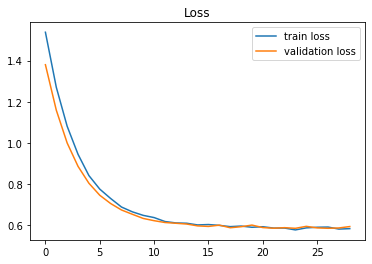

AUC 0.7566913294009342


 10%|████████▏                                                                         | 1/10 [03:05<27:53, 185.89s/it]

DAE learning curve 2/10


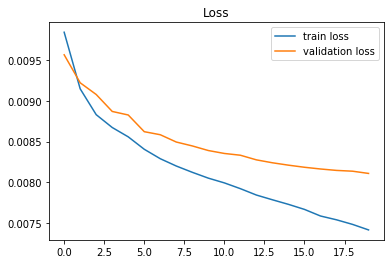

DNN learning curve 2/10


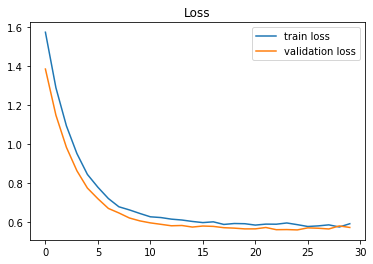

AUC 0.7640881873582767


 20%|████████████████▍                                                                 | 2/10 [06:17<24:59, 187.48s/it]

DAE learning curve 3/10


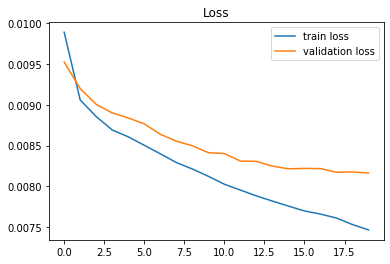

DNN learning curve 3/10


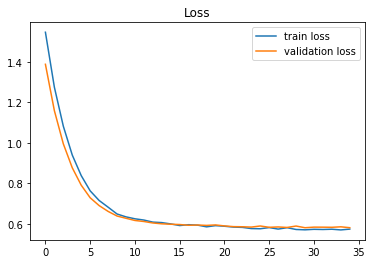

AUC 0.7563683386528963


 30%|████████████████████████▌                                                         | 3/10 [09:22<21:48, 186.88s/it]

DAE learning curve 4/10


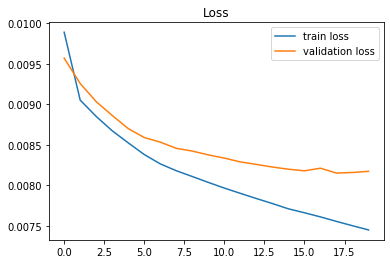

DNN learning curve 4/10


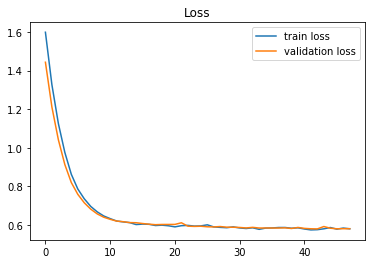

AUC 0.7755059148501772


 40%|████████████████████████████████▊                                                 | 4/10 [12:16<18:18, 183.02s/it]

DAE learning curve 5/10


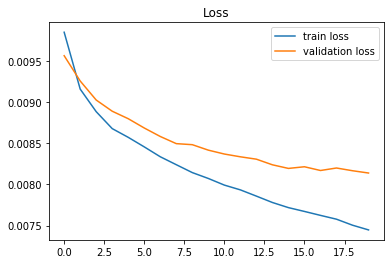

DNN learning curve 5/10


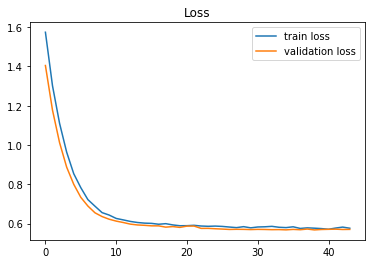

AUC 0.7586845965340665


 50%|█████████████████████████████████████████                                         | 5/10 [15:23<15:20, 184.12s/it]

DAE learning curve 6/10


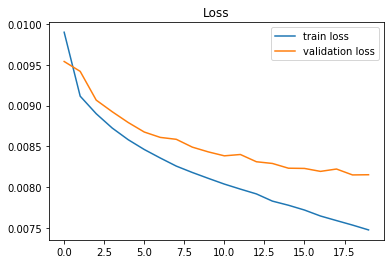

DNN learning curve 6/10


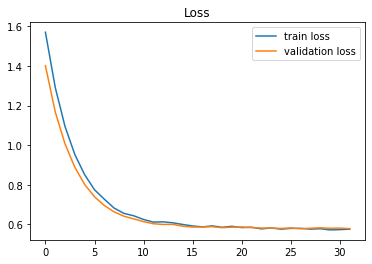

AUC 0.757588659802682


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:24<12:12, 183.20s/it]

DAE learning curve 7/10


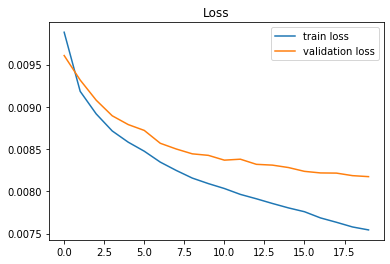

DNN learning curve 7/10


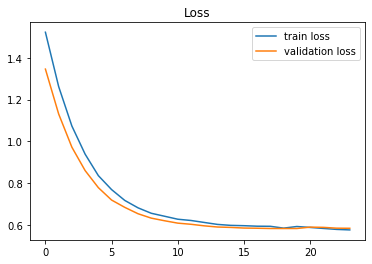

AUC 0.7352751324154885


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:20<09:03, 181.15s/it]

DAE learning curve 8/10


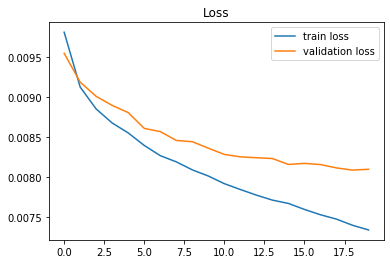

DNN learning curve 8/10


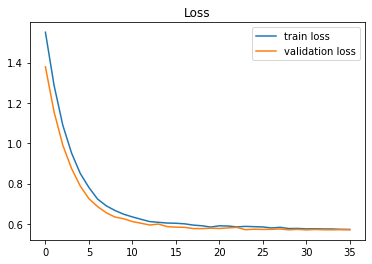

AUC 0.7681751736426464


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [24:20<06:01, 180.65s/it]

DAE learning curve 9/10


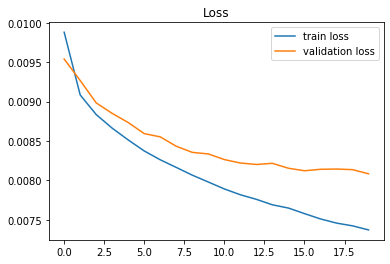

DNN learning curve 9/10


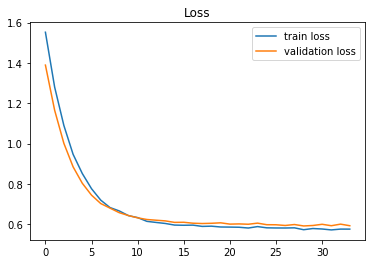

AUC 0.7355937431152235


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [27:19<03:00, 180.11s/it]

DAE learning curve 10/10


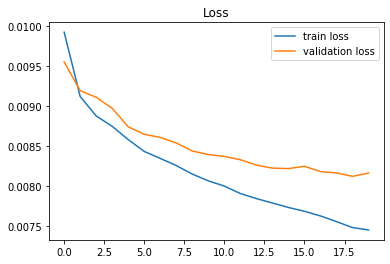

DNN learning curve 10/10


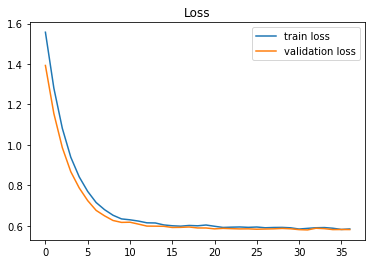

AUC 0.7543412003407962


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [30:29<00:00, 183.00s/it]



Validation Summary:
3    0.775506
7    0.768175
1    0.764088
4    0.758685
5    0.757589
0    0.756691
2    0.756368
9    0.754341
8    0.735594
6    0.735275
dtype: float64
mean=0.75623, std=0.013


In [11]:
# Set hyper-parameters for power mean ensemble 
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    X_train, X_test = train, test

    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    ##### STEP 2: Build DAE #####
    
    # Define the encoder dimension
    encoding_dim = 128

    # Input Layer
    input_dim = Input(shape = (X_train.shape[1], ))

    # Encoder Layers
    noise = Dropout(0.5)(input_dim) # for Denoising
    encoded1 = Dense(512, activation = 'relu')(noise)
    encoded2 = Dense(256, activation = 'relu')(encoded1)
    encoded3 = Dense(128, activation = 'relu')(encoded2)
    encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

    # Decoder Layers
    decoded1 = Dense(128, activation = 'relu')(encoded4)
    decoded2 = Dense(256, activation = 'relu')(decoded1)
    decoded3 = Dense(512, activation = 'relu')(decoded2)
    decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded4)

    # Compile the model
    autoencoder.compile(optimizer = 'adam', loss = 'mse')

    # Train the model
    history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                              shuffle=True, validation_data=(X_test,X_test), verbose=0)

    print(f'DAE learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    ##### STEP 3: Reduce Dimension #####
        
    # Use a middle Bottleneck Layer to Reduce Dimension
    model = Model(inputs=input_dim, outputs=encoded4)
    X_train = model.predict(X_train)
    X_test = model.predict(X_test)

    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.02)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=100, batch_size=128, 
                        validation_data=(valid_x,valid_y), callbacks=[EarlyStopping(patience=5)], verbose=0)

    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))     

[More Batchsize] Best!

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

DAE learning curve 1/10


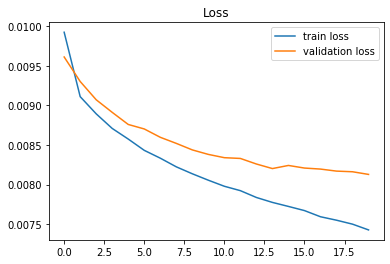

DNN learning curve 1/10


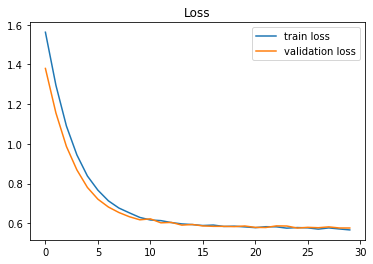

AUC 0.7531278105771201


 10%|████████▏                                                                         | 1/10 [03:02<27:26, 182.96s/it]

DAE learning curve 2/10


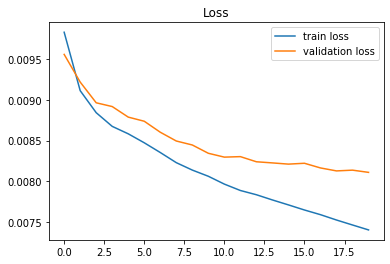

DNN learning curve 2/10


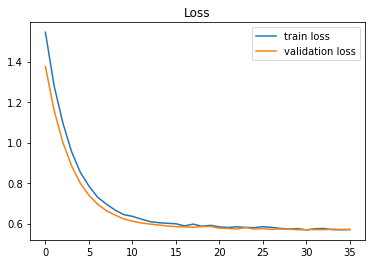

AUC 0.7640587644225773


 20%|████████████████▍                                                                 | 2/10 [06:00<24:10, 181.33s/it]

DAE learning curve 3/10


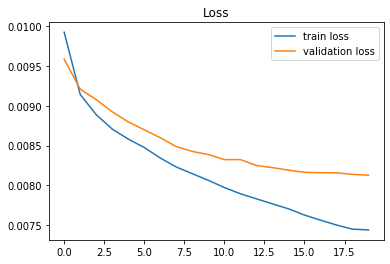

DNN learning curve 3/10


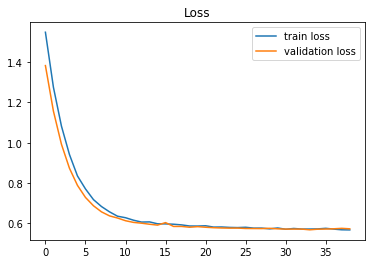

AUC 0.7567766844518325


 30%|████████████████████████▌                                                         | 3/10 [08:55<20:55, 179.35s/it]

DAE learning curve 4/10


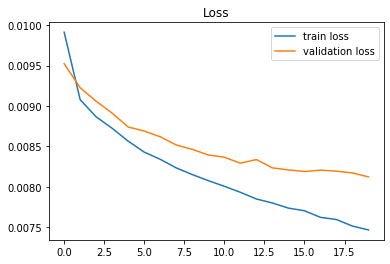

DNN learning curve 4/10


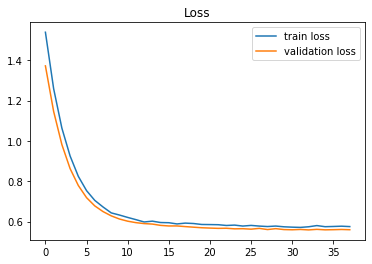

AUC 0.7739135009996844


 40%|████████████████████████████████▊                                                 | 4/10 [11:49<17:47, 177.94s/it]

DAE learning curve 5/10


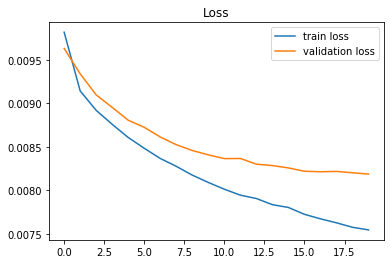

DNN learning curve 5/10


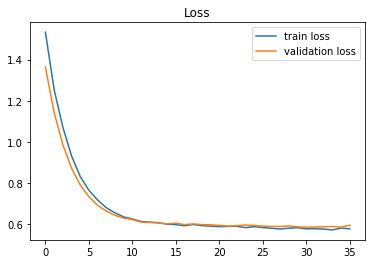

AUC 0.747863101604278


 50%|█████████████████████████████████████████                                         | 5/10 [14:47<14:49, 177.86s/it]

DAE learning curve 6/10


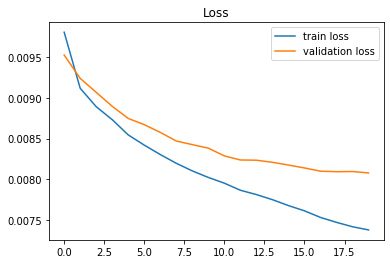

DNN learning curve 6/10


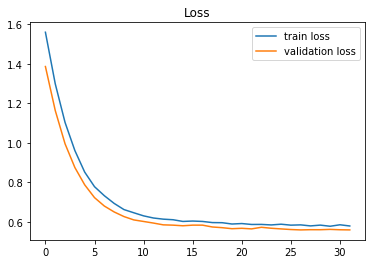

AUC 0.7787539726315238


 60%|█████████████████████████████████████████████████▏                                | 6/10 [17:39<11:44, 176.22s/it]

DAE learning curve 7/10


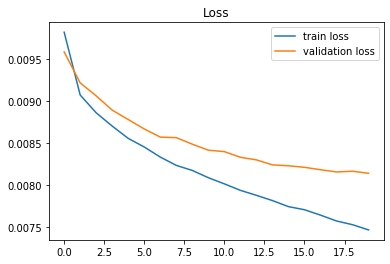

DNN learning curve 7/10


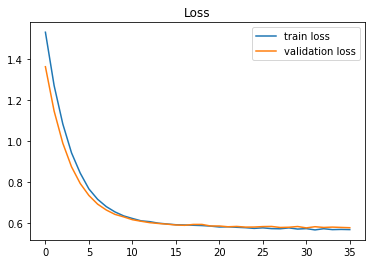

AUC 0.7551457004426785


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [20:30<08:43, 174.63s/it]

DAE learning curve 8/10


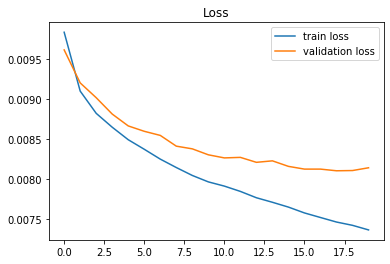

DNN learning curve 8/10


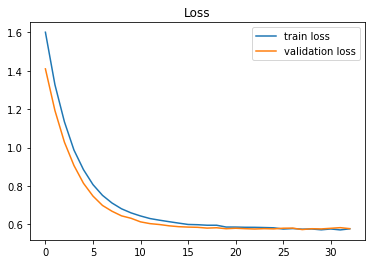

AUC 0.749117966946972


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [23:31<05:53, 176.54s/it]

DAE learning curve 9/10


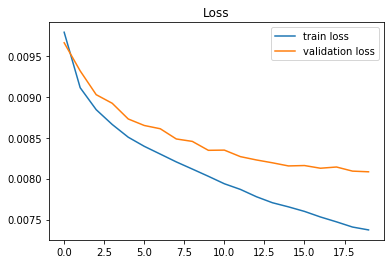

DNN learning curve 9/10


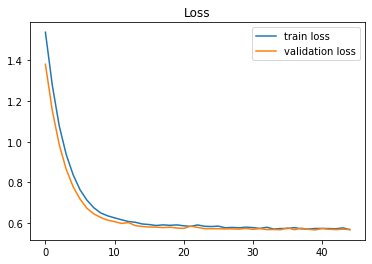

AUC 0.7580896326013513


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [26:30<02:57, 177.24s/it]

DAE learning curve 10/10


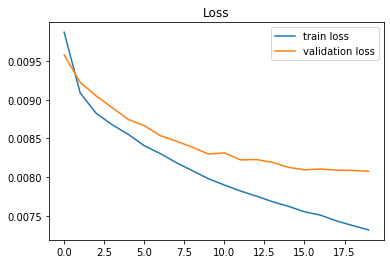

DNN learning curve 10/10


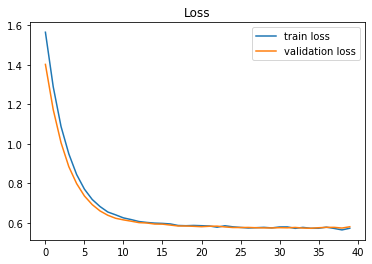

AUC 0.7525819839729926


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [29:24<00:00, 176.48s/it]



Validation Summary:
5    0.778754
3    0.773914
1    0.764059
8    0.758090
2    0.756777
6    0.755146
0    0.753128
9    0.752582
7    0.749118
4    0.747863
dtype: float64
mean=0.75894, std=0.010


In [9]:
# Set hyper-parameters for power mean ensemble 
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    X_train, X_test = train, test

    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    ##### STEP 2: Build DAE #####
    
    # Define the encoder dimension
    encoding_dim = 128

    # Input Layer
    input_dim = Input(shape = (X_train.shape[1], ))

    # Encoder Layers
    noise = Dropout(0.5)(input_dim) # for Denoising
    encoded1 = Dense(512, activation = 'relu')(noise)
    encoded2 = Dense(256, activation = 'relu')(encoded1)
    encoded3 = Dense(128, activation = 'relu')(encoded2)
    encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

    # Decoder Layers
    decoded1 = Dense(128, activation = 'relu')(encoded4)
    decoded2 = Dense(256, activation = 'relu')(decoded1)
    decoded3 = Dense(512, activation = 'relu')(decoded2)
    decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded4)

    # Compile the model
    autoencoder.compile(optimizer = 'adam', loss = 'mse')

    # Train the model
    history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                              shuffle=True, validation_data=(X_test,X_test), verbose=0)

    print(f'DAE learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    ##### STEP 3: Reduce Dimension #####
        
    # Use a middle Bottleneck Layer to Reduce Dimension
    model = Model(inputs=input_dim, outputs=encoded4)
    X_train = model.predict(X_train)
    X_test = model.predict(X_test)

    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.02)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=100, batch_size=128, 
                        validation_data=(valid_x,valid_y), callbacks=[EarlyStopping(patience=5)], verbose=0)

    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))     

In [10]:
# Power mean ensemble
THRESHOLD = 0.76  # Use only models whose AUC exceeds this value

pred = 0
n = 0
for i in range(N):
    if aucs.iloc[i] > THRESHOLD:
        pred = pred + preds[i]**p 
        n += 1
pred = pred / n    
pred = pred**(1/p)

# Make a submission file
t = pd.Timestamp.now()
fname = f"dae_p{p}n{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'dae_p3.5n3_submit_06140957.csv' is ready to submit.


n 증가


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

DAE learning curve 1/20


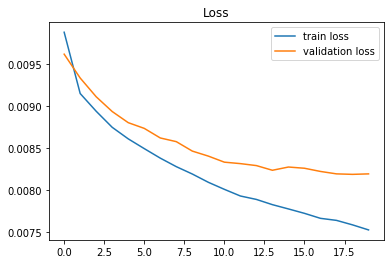

DNN learning curve 1/20


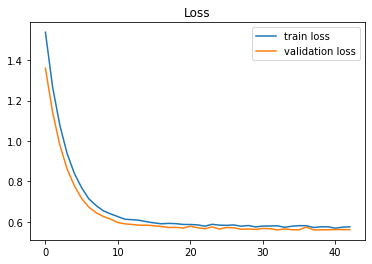

AUC 0.7640593776762775



  5%|████                                                                              | 1/20 [02:55<55:42, 175.94s/it]

DAE learning curve 2/20


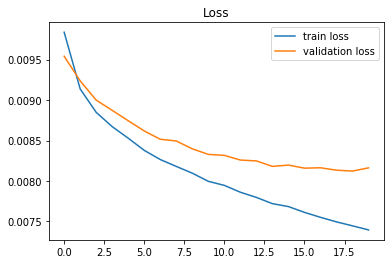

DNN learning curve 2/20


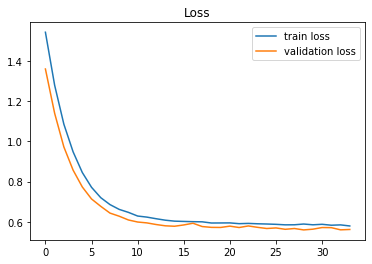

AUC 0.7722062783446711



 10%|████████▏                                                                         | 2/20 [06:03<53:49, 179.39s/it]

DAE learning curve 3/20


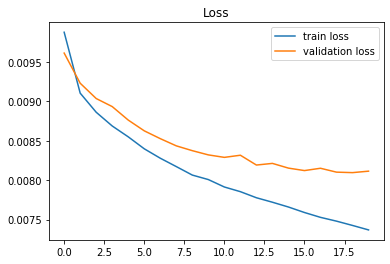

DNN learning curve 3/20


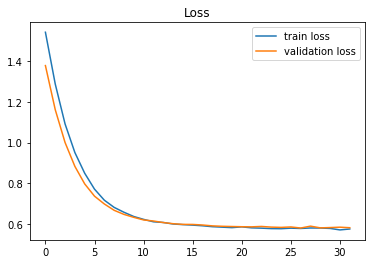

AUC 0.7485487039180609



 15%|████████████▎                                                                     | 3/20 [08:57<50:20, 177.66s/it]

DAE learning curve 4/20


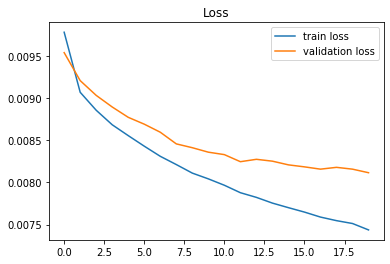

DNN learning curve 4/20


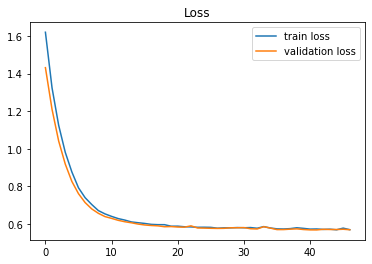

AUC 0.7626137195440762



 20%|████████████████▍                                                                 | 4/20 [12:10<48:38, 182.42s/it]

DAE learning curve 5/20


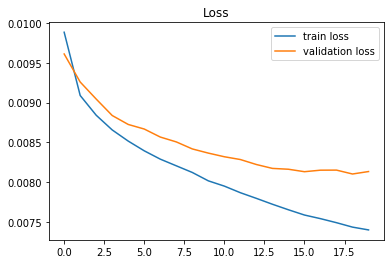

DNN learning curve 5/20


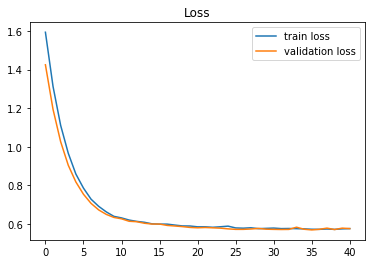

AUC 0.7668732312728016



 25%|████████████████████▌                                                             | 5/20 [16:02<49:18, 197.25s/it]

In [ ]:
N = 20
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    X_train, X_test = train, test

    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    ##### STEP 2: Build DAE #####
    
    # Define the encoder dimension
    encoding_dim = 128

    # Input Layer
    input_dim = Input(shape = (X_train.shape[1], ))

    # Encoder Layers
    noise = Dropout(0.5)(input_dim) # for Denoising
    encoded1 = Dense(512, activation = 'relu')(noise)
    encoded2 = Dense(256, activation = 'relu')(encoded1)
    encoded3 = Dense(128, activation = 'relu')(encoded2)
    encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

    # Decoder Layers
    decoded1 = Dense(128, activation = 'relu')(encoded4)
    decoded2 = Dense(256, activation = 'relu')(decoded1)
    decoded3 = Dense(512, activation = 'relu')(decoded2)
    decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded4)

    # Compile the model
    autoencoder.compile(optimizer = 'adam', loss = 'mse')

    # Train the model
    history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                              shuffle=True, validation_data=(X_test,X_test), verbose=0)

    print(f'DAE learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    ##### STEP 3: Reduce Dimension #####
        
    # Use a middle Bottleneck Layer to Reduce Dimension
    model = Model(inputs=input_dim, outputs=encoded4)
    X_train = model.predict(X_train)
    X_test = model.predict(X_test)

    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.02)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=100, batch_size=128, 
                        validation_data=(valid_x,valid_y), callbacks=[EarlyStopping(patience=5)], verbose=0)

    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))     

### Ensemble Models & Make Submissions

In [6]:
# Power mean ensemble
THRESHOLD = 0.77  # Use only models whose AUC exceeds this value

pred = 0
n = 0
for i in range(N):
    if aucs.iloc[i] > THRESHOLD:
        pred = pred + preds[i]**p 
        n += 1
pred = pred / n    
pred = pred**(1/p)

# Make a submission file
t = pd.Timestamp.now()
fname = f"dae_p{p}n{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'dae_p3.5n5_submit_06111502.csv' is ready to submit.


<font color='tomato'><font color="#CC3D3D"><p>
# End